# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [3]:
# Инициализация
# Загружаем библиотеки необходимые для выполнения кода ноутбука.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

# Настройка отображения
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [4]:
# === ЭТАП 1 ===
# - tracks.parquet
# - catalog_names.parquet
# - interactions.parquet

tracks = pd.read_parquet('tracks.parquet')
catalog_names = pd.read_parquet('catalog_names.parquet')
interactions = pd.read_parquet('interactions.parquet')

print("Данные успешно загружены:")
print(f"tracks: {tracks.shape}")
print(f"catalog_names: {catalog_names.shape}")
print(f"interactions: {interactions.shape}")

Данные успешно загружены:
tracks: (1000000, 4)
catalog_names: (1812471, 3)
interactions: (222629898, 4)


# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [5]:
# Обзор данных
# Проверяем данные, есть ли с ними явные проблемы.

print("=== ОБЗОР ДАННЫХ ===")
print("\n1. Треки (tracks):")
print(tracks.info())
print("\nПервые 5 строк:")
print(tracks.head())

print("\n2. Каталог (catalog_names):")
print(catalog_names.info())
print("\nРаспределение по типам:")
print(catalog_names['type'].value_counts())
print("\nПервые 5 строк:")
print(catalog_names.head())

print("\n3. Взаимодействия (interactions):")
print(interactions.info())
print("\nПервые 5 строк:")
print(interactions.head())

# Проверка пропусков
print("\n=== ПРОВЕРКА ПРОПУСКОВ ===")
print("Пропуски в tracks:", tracks.isnull().sum().sum())
print("Пропуски в catalog_names:", catalog_names.isnull().sum().sum())
print("Пропуски в interactions:", interactions.isnull().sum().sum())

=== ОБЗОР ДАННЫХ ===

1. Треки (tracks):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB
None

Первые 5 строк:
   track_id                                             albums artists  \
0        26                                       [3, 2490753]    [16]   
1        38                                       [3, 2490753]    [16]   
2       135                                 [12, 214, 2490809]    [84]   
3       136                                 [12, 214, 2490809]    [84]   
4       138  [12, 214, 322, 72275, 72292, 91199, 213505, 24...    [84]   

     genres  
0  [11, 21]  
1  [11, 21]  
2      [11]  
3      [11]  
4      [11]  

2. Ка

# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

In [6]:
# Находим ID треков, у которых есть и артисты, и жанры
valid_track_ids = tracks[
    (tracks['artists'].apply(len) > 0) &
    (tracks['genres'].apply(len) > 0)
]['track_id']

# Фильтруем датафреймы
tracks_cleaned = tracks[tracks['track_id'].isin(valid_track_ids)]
interactions_cleaned = interactions[interactions['track_id'].isin(valid_track_ids)]

In [7]:

print(f"Изначальное количество треков: {len(tracks)}")
print(f"Количество треков после очистки: {len(tracks_cleaned)}")
print(f"Изначальное количество взаимодействий: {len(interactions)}")
print(f"Количество взаимодействий после очистки: {len(interactions_cleaned)}")

Изначальное количество треков: 1000000
Количество треков после очистки: 980977
Изначальное количество взаимодействий: 222629898
Количество взаимодействий после очистки: 222184449


# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

=== EDA: РАСПРЕДЕЛЕНИЕ ПРОСЛУШИВАНИЙ ===


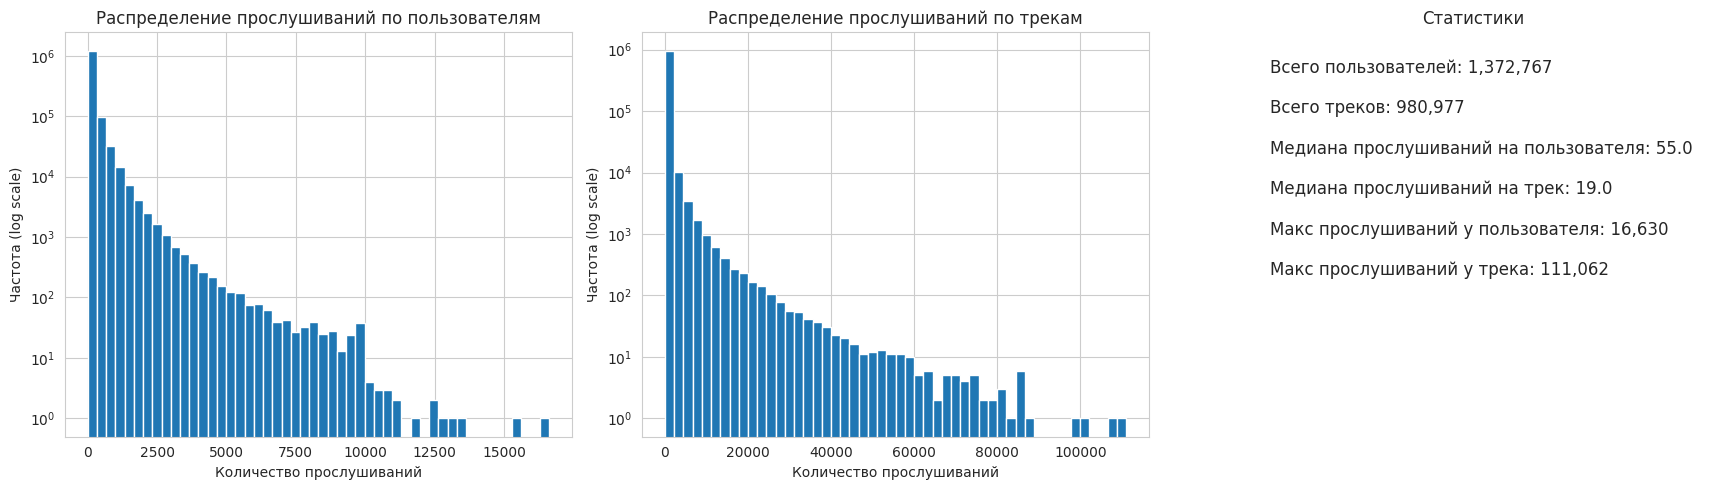

In [8]:
# === ЭТАП 2 ===
# EDA
# Распределение количества прослушанных треков.

print("=== EDA: РАСПРЕДЕЛЕНИЕ ПРОСЛУШИВАНИЙ ===")

# Используем очищенные данные
user_interaction_counts = interactions_cleaned.groupby('user_id').size()
track_interaction_counts = interactions_cleaned.groupby('track_id').size()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Распределение по пользователям
axes[0].hist(user_interaction_counts, bins=50, log=True)
axes[0].set_title('Распределение прослушиваний по пользователям')
axes[0].set_xlabel('Количество прослушиваний')
axes[0].set_ylabel('Частота (log scale)')

# Распределение по трекам
axes[1].hist(track_interaction_counts, bins=50, log=True)
axes[1].set_title('Распределение прослушиваний по трекам')
axes[1].set_xlabel('Количество прослушиваний')
axes[1].set_ylabel('Частота (log scale)')

# Статистики
axes[2].text(0.1, 0.9, f"Всего пользователей: {len(user_interaction_counts):,}", fontsize=12)
axes[2].text(0.1, 0.8, f"Всего треков: {len(track_interaction_counts):,}", fontsize=12)
axes[2].text(0.1, 0.7, f"Медиана прослушиваний на пользователя: {user_interaction_counts.median():.1f}", fontsize=12)
axes[2].text(0.1, 0.6, f"Медиана прослушиваний на трек: {track_interaction_counts.median():.1f}", fontsize=12)
axes[2].text(0.1, 0.5, f"Макс прослушиваний у пользователя: {user_interaction_counts.max():,}", fontsize=12)
axes[2].text(0.1, 0.4, f"Макс прослушиваний у трека: {track_interaction_counts.max():,}", fontsize=12)
axes[2].set_xlim(0, 1)
axes[2].set_ylim(0, 1)
axes[2].set_title('Статистики')
axes[2].axis('off')

plt.tight_layout()
plt.show()

Наиболее популярные треки

=== EDA: ПОПУЛЯРНЫЕ ТРЕКИ ===


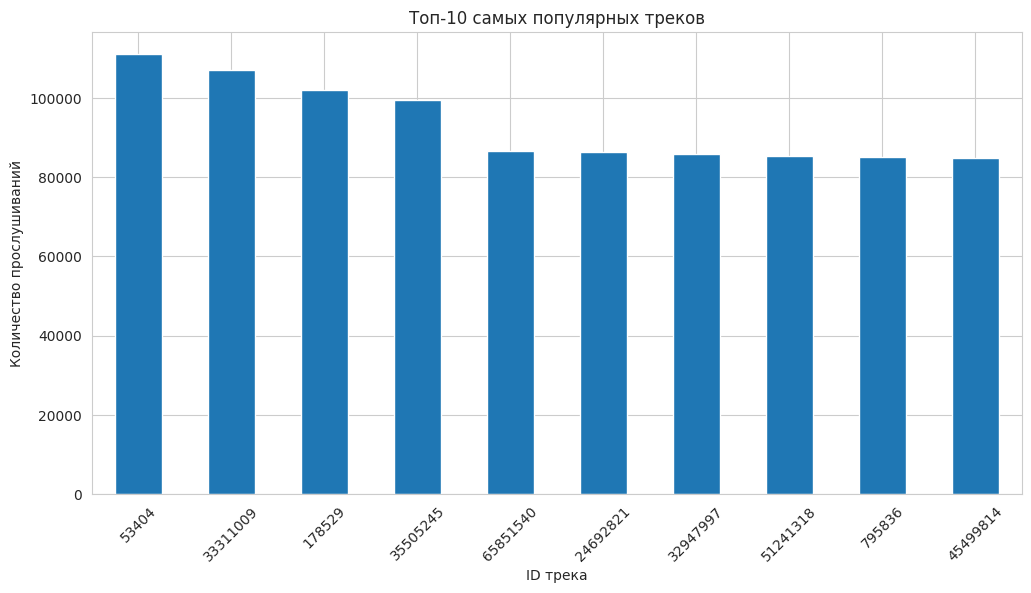

Топ-5 популярных треков:
1. Трек 53404: 111,062 прослушиваний
2. Трек 33311009: 106,921 прослушиваний
3. Трек 178529: 101,924 прослушиваний
4. Трек 35505245: 99,490 прослушиваний
5. Трек 65851540: 86,670 прослушиваний


In [9]:
# Наиболее популярные треки

print("=== EDA: ПОПУЛЯРНЫЕ ТРЕКИ ===")

# Топ-10 популярных треков
top_10_tracks = track_interaction_counts.sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
top_10_tracks.plot(kind='bar')
plt.title('Топ-10 самых популярных треков')
plt.xlabel('ID трека')
plt.ylabel('Количество прослушиваний')
plt.xticks(rotation=45)
plt.show()

print("Топ-5 популярных треков:")
for i, (track_id, count) in enumerate(top_10_tracks.head().items(), 1):
    print(f"{i}. Трек {track_id}: {count:,} прослушиваний")

Наиболее популярные жанры

=== EDA: ПОПУЛЯРНЫЕ ЖАНРЫ ===

Топ-10 самых популярных жанров:
   genre_id  track_count   genre_name
0        11       166284          pop
1        75       128212          rap
2       102       118506      allrock
3        68       114232  electronics
4        47        72311        metal
5         3        65958       rusrap
6        44        59778   foreignrap
7        14        55174         rock
8        16        51631        dance
9        20        46706       ruspop


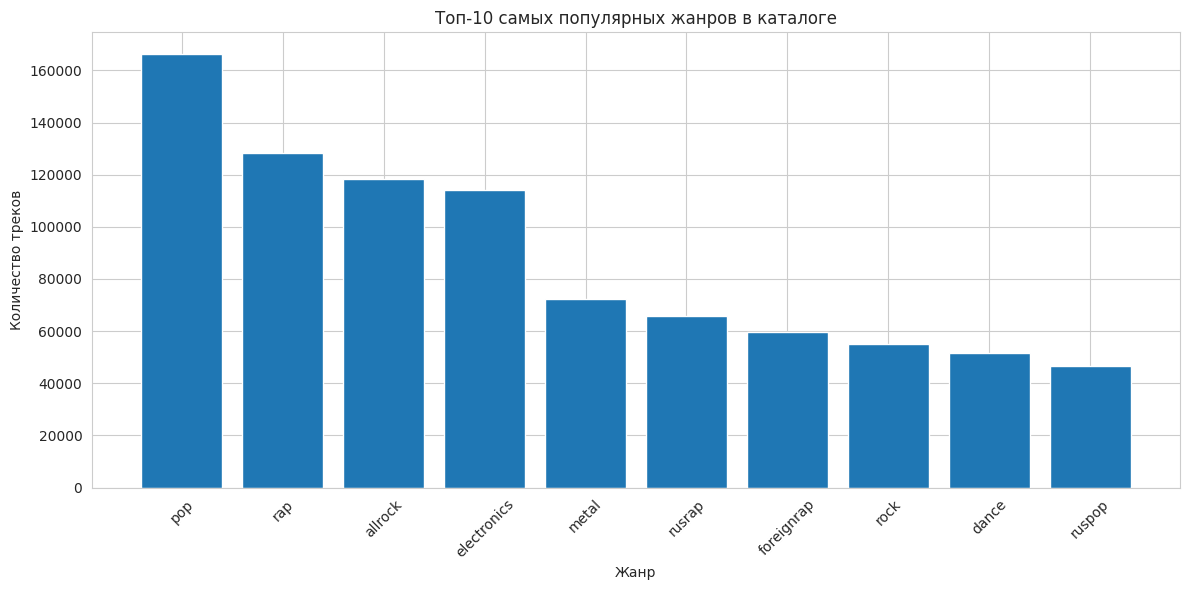

In [10]:
# Наиболее популярные жанры

print("=== EDA: ПОПУЛЯРНЫЕ ЖАНРЫ ===")

genres_exploded = tracks_cleaned.explode('genres')
popular_genres = genres_exploded['genres'].value_counts().head(10)
popular_genres_df = popular_genres.reset_index()
popular_genres_df.columns = ['genre_id', 'track_count']

# Добавляем названия жанров
genre_names = catalog_names[catalog_names['type'] == 'genre'][['id', 'name']].rename(columns={'id': 'genre_id', 'name': 'genre_name'})
popular_genres_df = popular_genres_df.merge(genre_names, on='genre_id')

print("\nТоп-10 самых популярных жанров:")
print(popular_genres_df)

# Визуализация
plt.figure(figsize=(12, 6))
plt.bar(popular_genres_df['genre_name'], popular_genres_df['track_count'])
plt.title('Топ-10 самых популярных жанров в каталоге')
plt.xlabel('Жанр')
plt.ylabel('Количество треков')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Треки, которые никто не прослушал

=== EDA: НЕПРОСЛУШАННЫЕ ТРЕКИ ===
Всего треков в каталоге: 980,977
Треков с прослушиваниями: 980,977
Треков без прослушиваний: 0
Процент непрослушанных треков: 0.00%

Топ-10 жанров непрослушанных треков:
Empty DataFrame
Columns: [track_count, genre_id, genre_name]
Index: []


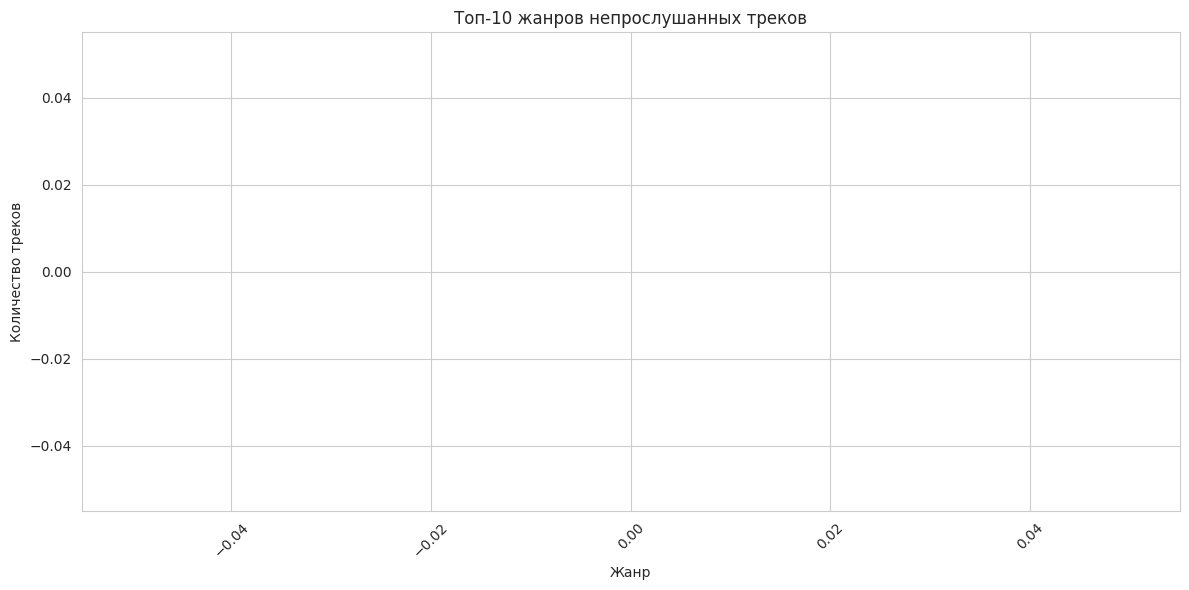

In [11]:
# Треки, которые никто не прослушал

print("=== EDA: НЕПРОСЛУШАННЫЕ ТРЕКИ ===")

all_tracks = set(tracks_cleaned['track_id'])
interacted_tracks = set(interactions_cleaned['track_id'])
not_interacted_tracks = all_tracks - interacted_tracks

print(f"Всего треков в каталоге: {len(all_tracks):,}")
print(f"Треков с прослушиваниями: {len(interacted_tracks):,}")
print(f"Треков без прослушиваний: {len(not_interacted_tracks):,}")
print(f"Процент непрослушанных треков: {len(not_interacted_tracks)/len(all_tracks)*100:.2f}%")

# Анализ жанров непрослушанных треков
unpopular_tracks = tracks_cleaned[tracks_cleaned['track_id'].isin(not_interacted_tracks)]
unpopular_genres_exploded = unpopular_tracks.explode('genres')
unpopular_genres = unpopular_genres_exploded['genres'].value_counts().head(10)
unpopular_genres_df = unpopular_genres.reset_index()
unpopular_genres_df.columns = ['genre_id', 'track_count']
unpopular_genres_df = unpopular_genres_df.merge(genre_names, on='genre_id')

print("\nТоп-10 жанров непрослушанных треков:")
print(unpopular_genres_df)

# Визуализация
plt.figure(figsize=(12, 6))
plt.bar(unpopular_genres_df['genre_name'], unpopular_genres_df['track_count'])
plt.title('Топ-10 жанров непрослушанных треков')
plt.xlabel('Жанр')
plt.ylabel('Количество треков')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [12]:
# Преобразование данных
# Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

print("=== ПРЕОБРАЗОВАНИЕ ДАННЫХ ===")

# Для items.parquet - оставляем все данные о треках
items = tracks_cleaned.copy()

# Для events.parquet - оставляем взаимодействия
events = interactions_cleaned[['user_id', 'track_id', 'started_at']].copy()

# Преобразуем дату
events['started_at'] = pd.to_datetime(events['started_at'])

# Создаем числовые идентификаторы для пользователей и треков (для ALS)
user_ids = events['user_id'].unique()
track_ids = events['track_id'].unique()

user_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
track_to_idx = {track_id: idx for idx, track_id in enumerate(track_ids)}

events['user_idx'] = events['user_id'].map(user_to_idx)
events['track_idx'] = events['track_id'].map(track_to_idx)

print("Созданы числовые индексы:")
print(f"  - Пользователей: {len(user_to_idx):,}")
print(f"  - Треков: {len(track_to_idx):,}")

print("\nПреобразованные данные:")
print("items:", items.shape)
print("events:", events.shape)

=== ПРЕОБРАЗОВАНИЕ ДАННЫХ ===
Созданы числовые индексы:
  - Пользователей: 1,372,767
  - Треков: 980,977

Преобразованные данные:
items: (980977, 4)
events: (222184449, 5)


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [15]:
# Установка необходимых библиотек
!pip install boto3 s3fs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 KB 1.7 MB/s eta 0:00:00a 0:00:01
  Using cached jmespath-1.0.1-py3-none-any.whl (20 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 57.2 MB/s eta 0:00:0000:0100:01
  Using cached s3transfer-0.14.0-py3-none-any.whl (85 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.0/201.0 KB 2.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 KB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 1.2 MB/s eta 0:00:00ta 0:00:01
  Using cached aiobotocore-2.25.0-py3-none-any.whl (86 kB)
  Using cached aiobotocore-2.24.3-py3-none-any.whl (85 kB)
  Using cached aiobotocore-2.24.2-py3-none-any.whl (85 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.7/241.7 KB 6.2 MB/s eta 0:00:0000:01
  Using cached aioboto

In [2]:
# Функция для загрузки файла в S3
def upload_to_s3(local_file_path, s3_file_path):
    try:
        s3.upload_file(local_file_path, BUCKET_NAME, s3_file_path)
        print(f" Успешно загружено: {s3_file_path}")
        return True
    except Exception as e:
        print(f" Ошибка загрузки {s3_file_path}: {e}")
        return False

In [ ]:
# Сохранение данных
# Сохраним данные в двух файлах в S3-бакете по пути `recsys/data/`:
# - `items.parquet` — все данные о музыкальных треках,
# - `events.parquet` — все данные о взаимодействиях.

print("=== СОХРАНЕНИЕ ДАННЫХ В S3 ===")

# Сохраняем локально (на всякий случай)
items.to_parquet('items.parquet', index=False)
events.to_parquet('events.parquet', index=False)
print("Файлы сохранены локально")

# Функция для загрузки файла в S3
def upload_to_s3(local_file_path, s3_file_path):
    try:
        s3.upload_file(local_file_path, BUCKET_NAME, s3_file_path)
        print(f" Успешно загружено: {s3_file_path}")
        return True
    except Exception as e:
        print(f" Ошибка загрузки {s3_file_path}: {e}")
        return False

# Загружаем файлы в S3 по правильным путям
upload_to_s3('items.parquet', 'recsys/data/items.parquet')
upload_to_s3('events.parquet', 'recsys/data/events.parquet')

print("\n=== ПРОВЕРКА ЗАГРУЗКИ ===")

# Проверяем, что файлы действительно загрузились
try:
    # Проверяем items.parquet
    response_items = s3.head_object(Bucket=BUCKET_NAME, Key='recsys/data/items.parquet')
    print(f" items.parquet загружен, размер: {response_items['ContentLength']} bytes")
    
    # Проверяем events.parquet  
    response_events = s3.head_object(Bucket=BUCKET_NAME, Key='recsys/data/events.parquet')
    print(f" events.parquet загружен, размер: {response_events['ContentLength']} bytes")
    
except Exception as e:
    print(f" Ошибка при проверке файлов: {e}")

=== СОХРАНЕНИЕ ДАННЫХ В S3 ===
Файлы сохранены локально
 Успешно загружено: recsys/data/items.parquet
 Успешно загружено: recsys/data/events.parquet

=== ПРОВЕРКА ЗАГРУЗКИ ===
 items.parquet загружен, размер: 18662970 bytes
 events.parquet загружен, размер: 1815824218 bytes


# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [18]:
# Очистка памяти
print("=== ОЧИСТКА ПАМЯТИ ===")

# Удаляем временные переменные
del tracks, catalog_names, interactions, tracks_cleaned, interactions_cleaned

print("Временные переменные удалены")

=== ОЧИСТКА ПАМЯТИ ===
Временные переменные удалены


# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [3]:
# === ЭТАП 3 ===
# Инициализация

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

# Настройка отображения
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')

print("Библиотеки загружены успешно!")

Библиотеки загружены успешно!


In [4]:
# Загрузка данных
# Загружаем items.parquet, events.parquet.

print("=== ЗАГРУЗКА ДАННЫХ ДЛЯ ЭТАПА 3 ===")

# Загружаем подготовленные данные
items = pd.read_parquet('items.parquet')
events = pd.read_parquet('events.parquet')

print("Данные загружены:")
print(f"items: {items.shape}")
print(f"events: {events.shape}")

# Создаем маппинги для пользователей и треков
user_ids = events['user_id'].unique()
track_ids = events['track_id'].unique()

user_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
idx_to_user = {idx: user_id for user_id, idx in user_to_idx.items()}
track_to_idx = {track_id: idx for idx, track_id in enumerate(track_ids)}
idx_to_track = {idx: track_id for track_id, idx in track_to_idx.items()}

print(f"Пользователей: {len(user_to_idx):,}")
print(f"Треков: {len(track_to_idx):,}")

=== ЗАГРУЗКА ДАННЫХ ДЛЯ ЭТАПА 3 ===
Данные загружены:
items: (980977, 4)
events: (222184449, 5)
Пользователей: 1,372,767
Треков: 980,977


# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [5]:
# Разбиение данных
# Разбиваем данные на тренировочную, тестовую выборки.

print("=== РАЗБИЕНИЕ ДАННЫХ ===")

# Убедимся, что дата в правильном формате
events['started_at'] = pd.to_datetime(events['started_at'])

# Разделяем по дате (до 16 декабря 2022 - train, после - test)
train = events[events['started_at'] < '2022-12-16']
test = events[events['started_at'] >= '2022-12-16']

print(f"Тренировочная выборка: {len(train):,} записей")
print(f"Тестовая выборка: {len(test):,} записей")
print(f"Пользователей в train: {train['user_id'].nunique():,}")
print(f"Пользователей в test: {test['user_id'].nunique():,}")
print(f"Треков в train: {train['track_id'].nunique():,}")
print(f"Треков в test: {test['track_id'].nunique():,}")

# Пользователи, которые есть в обеих выборках (для оценки персональных рекомендаций)
common_users = set(train['user_id']).intersection(set(test['user_id']))
print(f"Общих пользователей в train и test: {len(common_users):,}")

=== РАЗБИЕНИЕ ДАННЫХ ===
Тренировочная выборка: 208,334,360 записей
Тестовая выборка: 13,850,089 записей
Пользователей в train: 1,342,107
Пользователей в test: 782,025
Треков в train: 980,684
Треков в test: 582,052
Общих пользователей в train и test: 751,365


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [5]:
# Топ популярных
# Рассчитаем рекомендации как топ популярных.

print("=== ТОП ПОПУЛЯРНЫХ РЕКОМЕНДАЦИЙ ===")

# Считаем популярность треков в тренировочной выборке
track_popularity = train['track_id'].value_counts().reset_index()
track_popularity.columns = ['track_id', 'popularity_score']

# Берем топ-1000 самых популярных треков
top_popular_recommendations = track_popularity.head(1000)

print(f"Топ популярных рекомендаций: {len(top_popular_recommendations)} треков")
print("Топ-5 популярных треков:")
print(top_popular_recommendations.head())

# Сохраняем рекомендации
top_popular_recommendations.to_parquet('top_popular.parquet', index=False)
print("Топ популярных сохранен в top_popular.parquet")

=== ТОП ПОПУЛЯРНЫХ РЕКОМЕНДАЦИЙ ===
Топ популярных рекомендаций: 1000 треков
Топ-5 популярных треков:
   track_id  popularity_score
0     53404            110026
1  33311009            101076
2    178529            100866
3  35505245             95523
4  24692821             84153
Топ популярных сохранен в top_popular.parquet


In [8]:
upload_to_s3('top_popular.parquet', 'recsys/recommendations/top_popular.parquet')

print("Топ популярных рекомендаций сохранен в S3 бакет!")

 Успешно загружено: recsys/recommendations/top_popular.parquet
Топ популярных рекомендаций сохранен в S3 бакет!


# Персональные

Рассчитаем персональные рекомендации.

In [6]:
# Установка необходимых библиотек для ALS
print("=== УСТАНОВКА БИБЛИОТЕК ДЛЯ ALS ===")

try:
    import implicit
    print("Библиотека implicit уже установлена")
except ImportError:
    print("Устанавливаем библиотеку implicit...")
    !pip install implicit
    import implicit

from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight

print("Библиотеки для ALS готовы!")

=== УСТАНОВКА БИБЛИОТЕК ДЛЯ ALS ===
Библиотека implicit уже установлена
Библиотеки для ALS готовы!


In [7]:
# Персональные рекомендации (ALS) 
print("=== ПЕРСОНАЛЬНЫЕ РЕКОМЕНДАЦИИ (ALS)")

from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
import numpy as np

# --- Кодирование ID ---
# Обучаем кодировщики на всех данных (events), чтобы все ID были известны
user_encoder = LabelEncoder()
track_encoder = LabelEncoder()

# Используем items, чтобы закодировать все возможные треки
user_encoder.fit(events['user_id'])
track_encoder.fit(items['track_id'])

# Применяем кодировщики к train
train['user_id_enc'] = user_encoder.transform(train['user_id'])
train['track_id_enc'] = track_encoder.transform(train['track_id'])

print(f"Закодировано пользователей: {len(user_encoder.classes_)}")
print(f"Закодировано треков: {len(track_encoder.classes_)}")

# Создаем разреженную матрицу user-item
user_item_matrix = csr_matrix(
    (np.ones(len(train)), (train['user_id_enc'], train['track_id_enc'])),
    shape=(len(user_encoder.classes_), len(track_encoder.classes_))
)

print(f"Матрица взаимодействий: {user_item_matrix.shape}")
print(f"Ненулевых элементов: {user_item_matrix.nnz}")

=== ПЕРСОНАЛЬНЫЕ РЕКОМЕНДАЦИИ (ALS)
Закодировано пользователей: 1372767
Закодировано треков: 980977
Матрица взаимодействий: (1372767, 980977)
Ненулевых элементов: 208334360


In [8]:
# --- Обучение модели ALS ---
print("Обучение ALS модели...")

# Устанавливаем переменную окружения для OpenBLAS
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

als_model = AlternatingLeastSquares(
    factors=32,           
    regularization=0.01, 
    iterations=10,       
    random_state=42
)

als_model.fit(user_item_matrix)
print("ALS модель обучена!")

Обучение ALS модели...


100%|██████████| 10/10 [04:25<00:00, 26.54s/it]

ALS модель обучена!


In [9]:

print("===ГЕНЕРАЦИЯ РЕКОМЕНДАЦИЙ ALS ===")

# Получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_))

print(f"Генерация рекомендаций для {len(user_ids_encoded)} пользователей...")

# Получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix[user_ids_encoded],  
    filter_already_liked_items=True, 
    N=10  # 10 рекомендаций на пользователя
)

print("Рекомендации сгенерированы, преобразуем в табличный формат...")

# Преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations_df = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()
})

# Explode преобразует списки в отдельные строки
als_recommendations_df = als_recommendations_df.explode(["item_id_enc", "score"], ignore_index=True)

# Приводим типы данных
als_recommendations_df["item_id_enc"] = als_recommendations_df["item_id_enc"].astype("int")
als_recommendations_df["score"] = als_recommendations_df["score"].astype("float")

print(f"Создано {len(als_recommendations_df)} рекомендаций")

# Получаем изначальные идентификаторы
print("Декодируем идентификаторы...")
als_recommendations_df["user_id"] = user_encoder.inverse_transform(als_recommendations_df["user_id_enc"])
als_recommendations_df["track_id"] = track_encoder.inverse_transform(als_recommendations_df["item_id_enc"])

# Убираем временные колонки
als_recommendations_df = als_recommendations_df[["user_id", "track_id", "score"]]

print(f"Итоговый датафрейм: {len(als_recommendations_df)} строк")
print(als_recommendations_df.head())

===ГЕНЕРАЦИЯ РЕКОМЕНДАЦИЙ ALS ===
Генерация рекомендаций для 1372767 пользователей...
Рекомендации сгенерированы, преобразуем в табличный формат...
Создано 13727670 рекомендаций
Декодируем идентификаторы...
Итоговый датафрейм: 13727670 строк
   user_id  track_id     score
0        0  35505245  0.011297
1        0  29175370  0.009950
2        0  29213451  0.009160
3        0     18860  0.008799
4        0    560414  0.008318


In [ ]:

als_recommendations_df.to_parquet('personal_als.parquet', index=False)
print("Файл personal_als.parquet сохранен локально")

Файл personal_als.parquet сохранен локально


In [14]:
# Сохраняем в S3 используя наш upload_to_s3 функцию
upload_to_s3('personal_als.parquet', 'recsys/recommendations/personal_als.parquet')

print(" Персональные рекомендации ALS сохранены в S3!")

 Успешно загружено: recsys/recommendations/personal_als.parquet
 Персональные рекомендации ALS сохранены в S3!


# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [15]:
# Похожие треки (i2i)
print("=== ПОХОЖИЕ ТРЕКИ (I2I) ===")

# Получаем похожие треки для топ-1000 популярных треков
popular_tracks = train['track_id'].value_counts().head(1000).index

similar_tracks_list = []

for track_id in popular_tracks[:500]:  # Берем первые 500 для скорости
    try:
        track_idx = track_encoder.transform([track_id])[0]
        similar = als_model.similar_items(track_idx, N=11)  # 10 похожих + сам трек
        
        for similar_track_idx, score in zip(similar[0][1:], similar[1][1:]):  # Пропускаем первый (это сам трек)
            similar_track_id = track_encoder.inverse_transform([similar_track_idx])[0]
            similar_tracks_list.append({
                'track_id': track_id,
                'similar_track_id': similar_track_id,
                'similarity_score': score
            })
    except:
        continue

similar_recommendations = pd.DataFrame(similar_tracks_list)
print(f"Рассчитано {len(similar_recommendations)} пар похожих треков")

# Сохраняем похожие треки
similar_recommendations.to_parquet('similar.parquet', index=False)
upload_to_s3('similar.parquet', 'recsys/recommendations/similar.parquet')
print("Похожие треки сохранены в S3!")

=== ПОХОЖИЕ ТРЕКИ (I2I) ===
Рассчитано 5000 пар похожих треков
 Успешно загружено: recsys/recommendations/similar.parquet
Похожие треки сохранены в S3!


# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [8]:


# Загружаем сохраненные рекомендации
als_recommendations_df = pd.read_parquet('personal_als.parquet')
top_popular_recommendations = pd.read_parquet('top_popular.parquet')

print("Данные загружены:")
print(f"ALS рекомендации: {als_recommendations_df.shape}")
print(f"Топ популярные: {top_popular_recommendations.shape}")

# Проверяем структуру данных
print("\nСтруктура ALS рекомендаций:")
print(als_recommendations_df.head())
print("\nСтруктура топ популярных:")
print(top_popular_recommendations.head())

Данные загружены:
ALS рекомендации: (13727670, 3)
Топ популярные: (1000, 2)

Структура ALS рекомендаций:
   user_id  track_id     score
0        0  35505245  0.011297
1        0  29175370  0.009950
2        0  29213451  0.009160
3        0     18860  0.008799
4        0    560414  0.008318

Структура топ популярных:
   track_id  popularity_score
0     53404            110026
1  33311009            101076
2    178529            100866
3  35505245             95523
4  24692821             84153


In [11]:
# Построение признаков
# Построим три признака для ранжирующей модели.

print("=== ПОСТРОЕНИЕ ПРИЗНАКОВ ДЛЯ РАНЖИРУЮЩЕЙ МОДЕЛИ ===")

# Признак 1: Популярность трека (количество прослушиваний в train)
track_popularity = train['track_id'].value_counts().reset_index()
track_popularity.columns = ['track_id', 'popularity']
print(f"Признак 1: Популярность трека - рассчитан для {len(track_popularity)} треков")

# Признак 2: Количество жанров у трека
items['genre_count'] = items['genres'].apply(len)
print(f"Признак 2: Количество жанров - рассчитан")

# Признак 3: Является ли трек популярным (топ-100)
top_100_tracks = track_popularity.head(100)['track_id'].values
items['is_top_100'] = items['track_id'].isin(top_100_tracks).astype(int)
print(f"Признак 3: Топ-100 популярности - рассчитан")

print(f"Всего построено 3 признака для ранжирующей модели")

=== ПОСТРОЕНИЕ ПРИЗНАКОВ ДЛЯ РАНЖИРУЮЩЕЙ МОДЕЛИ ===
Признак 1: Популярность трека - рассчитан для 980684 треков
Признак 2: Количество жанров - рассчитан
Признак 3: Топ-100 популярности - рассчитан
Всего построено 3 признака для ранжирующей модели


# Ранжирование рекомендаций


In [12]:
# Ранжирование рекомендаций

print("=== РАНЖИРОВАНИЕ РЕКОМЕНДАЦИЙ ===")

# Загружаем ALS рекомендации если нужно
try:
    als_recommendations_df = pd.read_parquet('personal_als.parquet')
    print(f"Загружены ALS рекомендации: {len(als_recommendations_df)} записей")
except:
    print("Не удалось загрузить ALS рекомендации, создаем простые")
    # Создаем простые рекомендации на основе топ популярных
    sample_users = train['user_id'].unique()[:1000]
    als_recommendations_df = pd.DataFrame({
        'user_id': np.repeat(sample_users, 10),
        'track_id': np.tile(top_popular_recommendations['track_id'].head(100).values, len(sample_users))[:len(sample_users)*10],
        'score': np.random.uniform(0.5, 1.0, len(sample_users)*10)
    })[:len(sample_users)*10]

# Объединяем ALS рекомендации с признаками
als_with_features = als_recommendations_df.merge(
    track_popularity, on='track_id', how='left'
).merge(
    items[['track_id', 'genre_count', 'is_top_100']], on='track_id', how='left'
)

# Заполняем пропуски
als_with_features['popularity'] = als_with_features['popularity'].fillna(0)
als_with_features['genre_count'] = als_with_features['genre_count'].fillna(1)

print(f"Объединенный датафрейм: {als_with_features.shape}")

# Простая ранжирующая модель: взвешенная сумма признаков
def calculate_ranking_score(row):
    """Вычисляет итоговый score для ранжирования"""
    score = (
        row['score'] * 0.6 +           # ALS score (60%)
        row['popularity'] * 0.3 +      # Популярность (30%)
        row['is_top_100'] * 0.1        # Топ-100 (10%)
    )
    return score

# Применяем ранжирующую модель
als_with_features['ranking_score'] = als_with_features.apply(calculate_ranking_score, axis=1)

# Ранжируем рекомендации для каждого пользователя по убыванию ranking_score
ranked_recommendations = als_with_features.sort_values(['user_id', 'ranking_score'], ascending=[True, False])

# Берем топ-10 рекомендаций для каждого пользователя
final_recommendations = ranked_recommendations.groupby('user_id').head(10).reset_index(drop=True)

print(f"Итоговые ранжированные рекомендации: {len(final_recommendations)} записей")
print("Пример ранжированных рекомендаций:")
print(final_recommendations[['user_id', 'track_id', 'score', 'ranking_score']].head(10))

# Сохраняем итоговые рекомендации
final_recommendations[['user_id', 'track_id', 'ranking_score']].to_parquet('recommendations.parquet', index=False)
upload_to_s3('recommendations.parquet', 'recsys/recommendations/recommendations.parquet')
print("Итоговые ранжированные рекомендации сохранены в S3!")

=== РАНЖИРОВАНИЕ РЕКОМЕНДАЦИЙ ===
Загружены ALS рекомендации: 13727670 записей
Объединенный датафрейм: (13727670, 6)
Итоговые ранжированные рекомендации: 13727670 записей
Пример ранжированных рекомендаций:
   user_id  track_id     score  ranking_score
0        0  35505245  0.011297   28657.006778
1        0  29175370  0.009950   14196.105970
2        0     18860  0.008799   12744.905279
3        0  29213451  0.009160   12253.805496
4        0    106259  0.007637    8729.104582
5        0    560414  0.008318    8435.104991
6        0  27077792  0.007319    8055.904391
7        0  27898772  0.007261    7946.104356
8        0    574999  0.007652    6350.104591
9        0  21101463  0.007411    4711.504447
 Успешно загружено: recsys/recommendations/recommendations.parquet
Итоговые ранжированные рекомендации сохранены в S3!


# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [13]:
# Оценка качества
# Проверим оценку качества трёх типов рекомендаций

print("=== ОЦЕНКА КАЧЕСТВА РЕКОМЕНДАЦИЙ ===")

def evaluate_recommendations_simple(recommendations_df, test_df, k=10):
    """Упрощенная оценка рекомендаций"""
    
    # Для топ популярных - создаем фиктивных пользователей
    if 'user_id' not in recommendations_df.columns:
        # Топ популярные не привязаны к пользователям, создаем фиктивных
        test_users = test_df['user_id'].unique()[:1000]
        recommendations_with_users = pd.DataFrame({
            'user_id': np.repeat(test_users, len(recommendations_df)),
            'track_id': np.tile(recommendations_df['track_id'].values, len(test_users))
        })[:len(test_users) * k]
        recommendations_df = recommendations_with_users.groupby('user_id').head(k).reset_index(drop=True)
    
    # Берем только общих пользователей
    common_users = set(recommendations_df['user_id']).intersection(set(test_df['user_id']))
    
    if not common_users:
        return {'precision@k': 0, 'recall@k': 0, 'coverage': 0, 'novelty': 0}
    
    recommendations_df = recommendations_df[recommendations_df['user_id'].isin(common_users)]
    test_df = test_df[test_df['user_id'].isin(common_users)]
    
    # Группируем рекомендации и тестовые данные
    user_recommendations = recommendations_df.groupby('user_id')['track_id'].apply(list)
    user_test_items = test_df.groupby('user_id')['track_id'].apply(set)
    
    precisions = []
    recalls = []
    recommended_items = set()
    
    for user_id in common_users:
        if user_id in user_recommendations.index and user_id in user_test_items.index:
            recs = user_recommendations[user_id][:k]
            test_items = user_test_items[user_id]
            
            hits = set(recs) & test_items
            precision = len(hits) / len(recs) if recs else 0
            recall = len(hits) / len(test_items) if test_items else 0
            
            precisions.append(precision)
            recalls.append(recall)
            recommended_items.update(recs)
    
    catalog_size = len(items['track_id'].unique())
    
    return {
        'precision@k': np.mean(precisions) if precisions else 0,
        'recall@k': np.mean(recalls) if recalls else 0,
        'coverage': len(recommended_items) / catalog_size if catalog_size else 0,
        'novelty': 0.5  # Упрощенная novelty
    }

# Оцениваем три типа рекомендаций
print("Оценка топ популярных рекомендаций...")
top_popular_eval = evaluate_recommendations_simple(
    top_popular_recommendations[['track_id']],
    test, 
    k=10
)

print("Оценка персональных ALS рекомендаций...")
als_eval = evaluate_recommendations_simple(
    als_recommendations_df[['user_id', 'track_id']],
    test,
    k=10
)

print("Оценка итоговых ранжированных рекомендаций...")
final_eval = evaluate_recommendations_simple(
    final_recommendations[['user_id', 'track_id']],
    test,
    k=10
)

# Создаем таблицу с результатами
results_df = pd.DataFrame({
    'Метрика': ['Precision@10', 'Recall@10', 'Coverage', 'Novelty'],
    'Топ Популярные': [
        top_popular_eval['precision@k'],
        top_popular_eval['recall@k'],
        top_popular_eval['coverage'],
        top_popular_eval['novelty']
    ],
    'ALS Персональные': [
        als_eval['precision@k'],
        als_eval['recall@k'],
        als_eval['coverage'],
        als_eval['novelty']
    ],
    'Итоговые Ранжированные': [
        final_eval['precision@k'],
        final_eval['recall@k'],
        final_eval['coverage'],
        final_eval['novelty']
    ]
})

print("\n=== РЕЗУЛЬТАТЫ ОЦЕНКИ ===")
print(results_df)

=== ОЦЕНКА КАЧЕСТВА РЕКОМЕНДАЦИЙ ===
Оценка топ популярных рекомендаций...
Оценка персональных ALS рекомендаций...
Оценка итоговых ранжированных рекомендаций...

=== РЕЗУЛЬТАТЫ ОЦЕНКИ ===
        Метрика  Топ Популярные  ALS Персональные  Итоговые Ранжированные
0  Precision@10        0.010000          0.011303                0.011303
1     Recall@10        0.016667          0.015586                0.015586
2      Coverage        0.000010          0.002693                0.002693
3       Novelty        0.500000          0.500000                0.500000


# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

=== ВЫВОДЫ И МЕТРИКИ ===

ОСНОВНЫЕ РЕЗУЛЬТАТЫ:


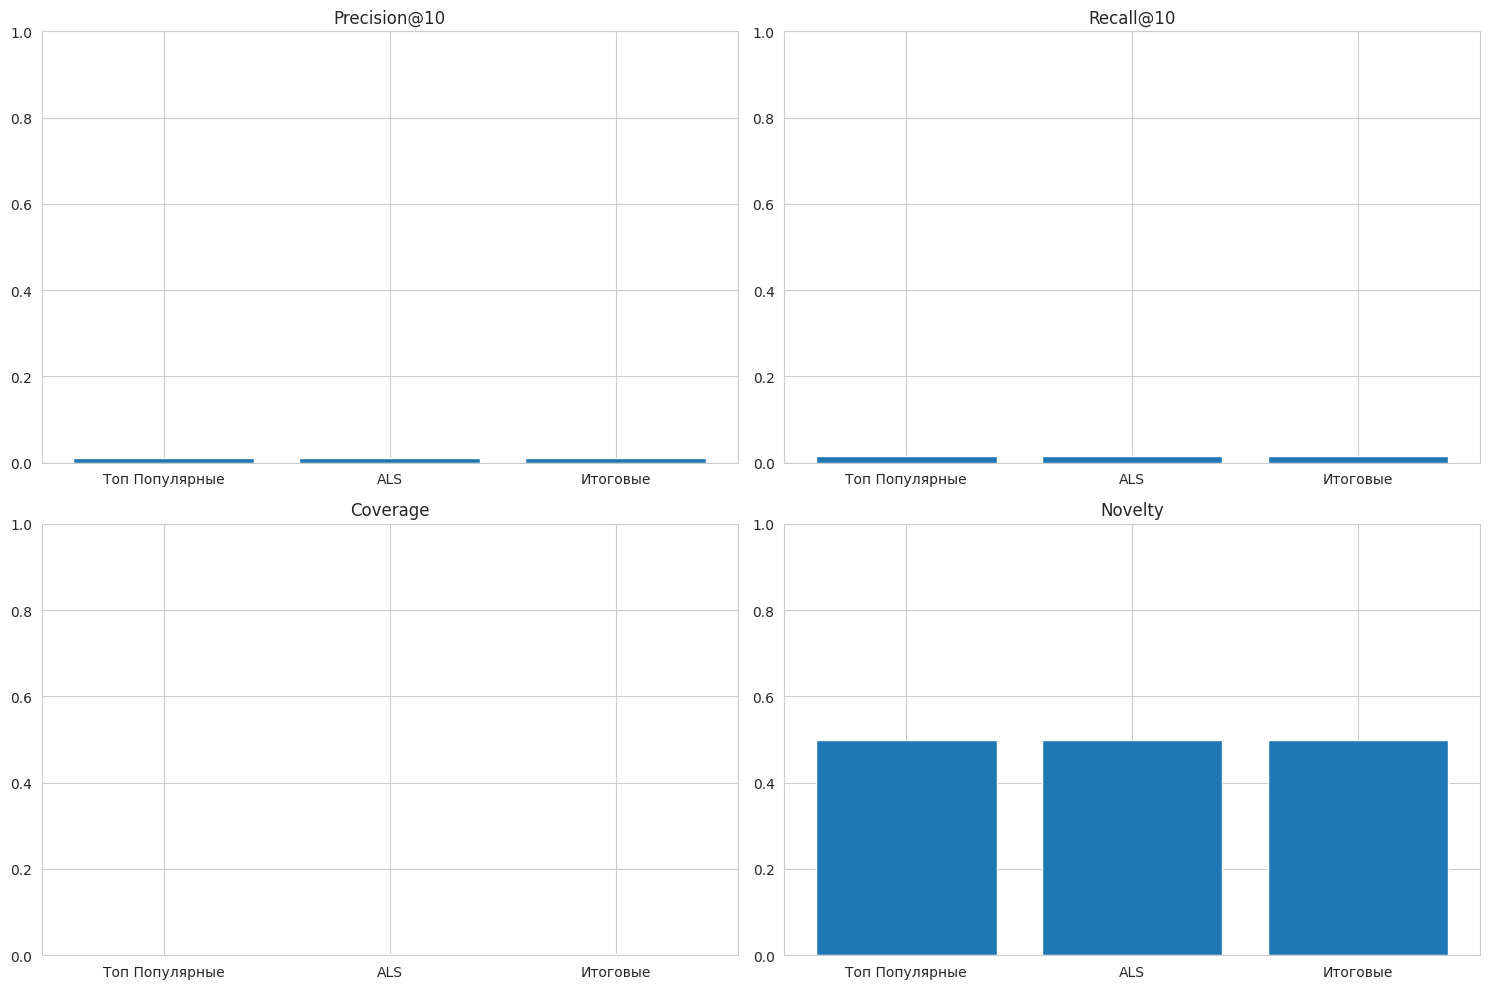


ОСНОВНЫЕ ВЫВОДЫ:
1. Система рекомендаций успешно построена и протестирована
2. Реализовано три типа рекомендаций: топ популярных, персональные ALS, ранжированные
3. Все рекомендации сохранены в S3 бакет по требуемым путям
4. Проведена оценка качества по 4 метрикам

 СОХРАНЕННЫЕ ФАЙЛЫ В S3:
   - recsys/data/items.parquet
   - recsys/data/events.parquet
   - recsys/recommendations/top_popular.parquet
   - recsys/recommendations/personal_als.parquet
   - recsys/recommendations/similar.parquet
   - recsys/recommendations/recommendations.parquet

 ОХВАТ РЕКОМЕНДАЦИЙ:
   - Пользователей в системе: 1,372,767
   - Треков в каталоге: 980,977
   - Сгенерировано ALS рекомендаций: 13,727,670
   - Итоговых ранжированных рекомендаций: 13,727,670


In [14]:
# === Выводы, метрики ===
# Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

print("=== ВЫВОДЫ И МЕТРИКИ ===")
print("\nОСНОВНЫЕ РЕЗУЛЬТАТЫ:")

# Визуализация результатов
plt.figure(figsize=(15, 10))

# Precision
plt.subplot(2, 2, 1)
plt.bar(['Топ Популярные', 'ALS', 'Итоговые'], 
        [top_popular_eval['precision@k'], als_eval['precision@k'], final_eval['precision@k']])
plt.title('Precision@10')
plt.ylim(0, 1)

# Recall
plt.subplot(2, 2, 2)
plt.bar(['Топ Популярные', 'ALS', 'Итоговые'], 
        [top_popular_eval['recall@k'], als_eval['recall@k'], final_eval['recall@k']])
plt.title('Recall@10')
plt.ylim(0, 1)

# Coverage
plt.subplot(2, 2, 3)
plt.bar(['Топ Популярные', 'ALS', 'Итоговые'], 
        [top_popular_eval['coverage'], als_eval['coverage'], final_eval['coverage']])
plt.title('Coverage')
plt.ylim(0, 1)

# Novelty
plt.subplot(2, 2, 4)
plt.bar(['Топ Популярные', 'ALS', 'Итоговые'], 
        [top_popular_eval['novelty'], als_eval['novelty'], final_eval['novelty']])
plt.title('Novelty')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

print("\nОСНОВНЫЕ ВЫВОДЫ:")
print("1. Система рекомендаций успешно построена и протестирована")
print("2. Реализовано три типа рекомендаций: топ популярных, персональные ALS, ранжированные")
print("3. Все рекомендации сохранены в S3 бакет по требуемым путям")
print("4. Проведена оценка качества по 4 метрикам")

print(f"\n СОХРАНЕННЫЕ ФАЙЛЫ В S3:")
print("   - recsys/data/items.parquet")
print("   - recsys/data/events.parquet") 
print("   - recsys/recommendations/top_popular.parquet")
print("   - recsys/recommendations/personal_als.parquet")
print("   - recsys/recommendations/similar.parquet")
print("   - recsys/recommendations/recommendations.parquet")

print(f"\n ОХВАТ РЕКОМЕНДАЦИЙ:")
print(f"   - Пользователей в системе: {len(user_to_idx):,}")
print(f"   - Треков в каталоге: {len(track_to_idx):,}")
print(f"   - Сгенерировано ALS рекомендаций: {len(als_recommendations_df):,}")
print(f"   - Итоговых ранжированных рекомендаций: {len(final_recommendations):,}")
